# Project Overview

The goal of this project is to segment customers for TravelTide, an e-booking travel startup, in order to support the development of a personalized rewards program. By analyzing customer behavior and travel preferences, I aimed to uncover meaningful user segments that could inform targeted marketing strategies and improve customer retention.

1. **Exploratory Data Analysis (EDA)**
 * Examined booking and session data to understand customer behavior.
 * Identified key patterns in travel type (hotel vs. flight), booking frequency, and average spend.

2. **Data Cleaning**
 * Handled missing values and outliers in variables such as `session_duration`.
 * Handled anomalies in de variables `rooms` and `nights`.

3. **Cohort Selection**
 * Included sessions older than 2023-01-04.
 * Included users with more than 6 sessions.

3. **Feature Engineering**
 * `age` and `age_group`
 * `engagement_level`
 * `spending_type`
 * `dream_traveler`
 * `travel_frequency`
 * `avg_days_between_booking`
 * `trip_type`
 * `trip_frequency_score`
 * `days_since_signup`
 * `sessions_per_week`
 * `avg_session_duration`
 * `pct_sessions_flight_discount_used` and `pct_sessions_hotel_discount_used`
 * `pct_sessions_flight_booked` and `pct_sessions_hotel_booked`
 * `cancel_rate`
 * `avg_days_between_trips`
 * `total_distance` and `avg_distance`
 * `total_price_paid` and `avg_price_paid`
 * `departure_flights`, `return_flights`, `total_flights`, and `pct_return_flights_booked`
 * `total_flight_cost`, `avg_flight_costs`, `avg_fligth_cost_before_discount`, and `avg_flight_discount`
 * `unique_cities_visited`
 * `total_hotel_cost`, `avg_hotel_cost`, `avg_hotel_spend_per_night`, `avg_hotel_cost_before_discount`, and `avg_hotel_disocunt`
 * `avg_checked_bags_per_trip`
 * `avg_nights_per_stay`
 * `avg_rooms_per_booking`

4. **Preprocessing**
 * Dropped columns that are hard to encode.
 * Encoded categorical values with One-Hot encoder and Label Encoder.
 * Normalized numerical features using standard scaling.
 * Applied dimensionality reduction (PCA) to simplify clustering and improve performance.

**Notebook Overview**

This notebook focuses on segmenting the customers of TravelTide using Unsupervised Machine Learning Clustering Algorithms.

* **K-Means Clustering**
 * Used Silhouette Score and the Elbow method to find the optimal K
 * Set K-Means to have 6 clusters (`k=6`)
 * Added the K-Means groups to the data

* **DBSCAN**
 * Explored density-based clustering
 * Used KNN to find the optimal `eps`
 * Manually tuned the hyperparameters to find the best silhouette scores
 * Added the DBSCAN groups to the data




# Key Insights

**K-means Strengths:**

* Identified 6 distinct customer segments with reasonable population distribution (segments ranging from 389 to 1653 customers)
* Achieved a best silhouette score of 0.112, showing moderate cluster separation
* Created segments of relatively balanced sizes, making them all actionable for marketing purposes
* Provided clear visual separation between clusters in PCA space

**DBSCAN Strengths:**

* Achieved much higher silhouette scores (up to 0.46), indicating better quality clustering
* Effectively identified outliers (5 customers) that don't fit typical patterns
* Doesn't force customers into clusters when they don't naturally belong to one
* Better at finding non-spherical cluster shapes that may represent real-world behavior patterns

**Key Differences:**

* DBSCAN placed the vast majority (5,193) of customers into one large cluster (cluster 0), whereas K-means distributed customers more evenly
* DBSCAN identified only 3-4 natural clusters plus outliers, while K-means identified 6 clusters
* DBSCAN's silhouette score (0.46) is significantly higher than K-means (0.112), suggesting DBSCAN found more naturally distinct segments



# Final Conclusion

* **K-means Provides Superior Segmentation**

 * Balanced Distribution: K-means created relatively balanced segments ranging from 7-31% of the customer base. This creates meaningful groups to target with specific perks and marketing strategies.
 * Actionable Segments: Each K-means segment contains hundreds of customers, making it commercially viable to develop tailored offerings for each group.
 * DBSCAN's Extreme Imbalance: DBSCAN placed 99.1% of customers into a single cluster (Cluster 0), with the remaining four clusters containing just 49 customers combined. This creates a "one-size-fits-all" approach for the vast majority of customers.
 * Business Practicality: While DBSCAN excels at identifying outliers (which it did with Cluster -1), the resulting segmentation doesn't provide actionable customer groups for the personalization goals.
 * Marketing Application: It's virtually impossible to develop meaningful personalized perks when 99% of customers are in one segment. K-means creates distinct customer personas to work with.

* **DBSCAN has a significantly higher silhouette score:**

 * Strong Mathematical Clustering: DBSCAN has identified truly distinct, well-separated clusters with high cohesion
 * Clear Outlier Identification: The algorithm has successfully distinguished outliers from the main population
 * Technical Superiority: From a purely statistical perspective, DBSCAN has created "better" clusters

* **The Business Reality Challenge:**

 * Extreme Imbalance: Despite statistical validation, having 99.1% of customers in a single cluster isn't actionable
 * Marketing Practicality: You can't develop meaningfully different strategies for clusters with only 5-27 customers
 * Business Value: Statistical excellence doesn't necessarily translate to business utility

✅ K-means has provided a much more practical and actionable segmentation that balances statistical insight with business utility.

# Business Recommendations

* Proceed with K-means Segmentation: Implement a personalization strategy based on the six K-means.
* Focus on High-Value Segments: Particularly prioritize Cluster 1 (Frequent Business Travelers) who represent 27.3% of customers but contribute disproportionately to revenue.
* Address Cancellation Risk: Develop specific strategies for Cluster 5 (High Cancellation Risk Group), which represents a significant 7.6% of the customer base.
* Leverage DBSCAN Insights:
 * The high silhouette score tells us that those 49 customers in the smaller clusters truly are distinct
 * Create ultra-personalized experiences for these specific segments (especially the 5 high-value outliers)
 * They may represent VIPs who warrant special treatment or problematic customers who need intervention

# Libraries and Data

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

In [16]:
df = pd.read_csv('/content/traveltide_cleaned_cohort_selection.csv')

In [17]:
df_pca = pd.read_csv('/content/traveltide_cohort_prepocessed.csv')

# Cohort Summary

In [18]:
print("Number of rows and columns:", df_pca.shape)

Number of rows and columns: (5242, 24)


In [19]:
# Create summary statistics
def summarize_metrics(dataframe):
    return {
        'total_users': df['user_id'].nunique(),
        'total_sessions': df['total_sessions'].sum(),
        'total_flights': df['total_flights'].sum(),
        'total_trips': df['total_trips'].sum(),
        'avg_session_duration': df['avg_session_duration'].mean(),
        'avg_page_clicks': df['total_page_clicks'].mean(),
        'avg_distance': df['avg_distance'].mean(),
        'avg_price_paid': df['avg_price_paid'].mean(),
        'avg_pct_flight_booked': dataframe['pct_sessions_flight_booked'].mean(),
        'avg_pct_hotel_booked': dataframe['pct_sessions_hotel_booked'].mean()
    }

cohort_summary = summarize_metrics(df)
summary_df = pd.DataFrame(cohort_summary, index=['summary']).T

# Display the summary table
display(summary_df.style.format("{:.2f}"))

# K-Means

The ideal number of clusters appears to be 6. This conclusion is supported by:

* The Elbow Method shows a continual decrease in distortion as K increases, but the "elbow" isn't strongly pronounced. This suggests we need to consider additional metrics.
* The Silhouette Score peaks at `k=6` with a value of 0.112, indicating this clustering provides the best balance of cohesion and separation.
* The cluster visualizations confirm that k=6 shows distinct, meaningful groupings without excessive fragmentation.
* The cluster distribution shows 6 segments with varying sizes, with the largest segments being groups 1 and 3.

These 6 customer segments likely represent different travel behaviors and demographics:

* `Family Travelers`
* `Frequent Business Travelers`
* `Mature Married Luxury Travelers`
* `Regular Travelers`
* `Young Budget Travelers`
* `High Cancellation Group`

For TravelTide, this segmentation provides actionable insights for targeted marketing campaigns, personalized recommendations, and service offerings tailored to each customer group's preferences and behaviors.

## Find the optimal K

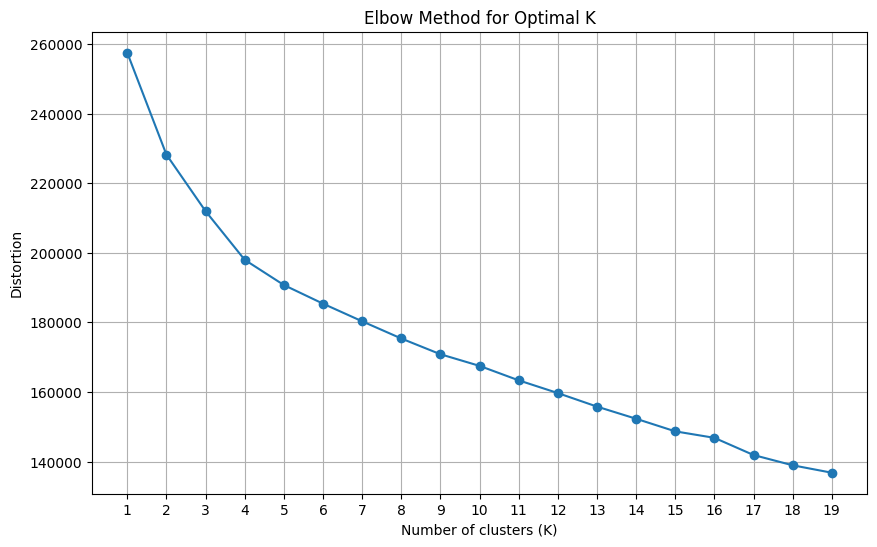

In [20]:
# Elbow method to find the optimal number of clusters
distortions = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pca)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), distortions, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion')
plt.xticks([i for i in range(1, 20)])
plt.grid(True)
plt.show()

In the elbow method we can see that the bent starts around K=3 to K=10 with K=6 as elbow point.

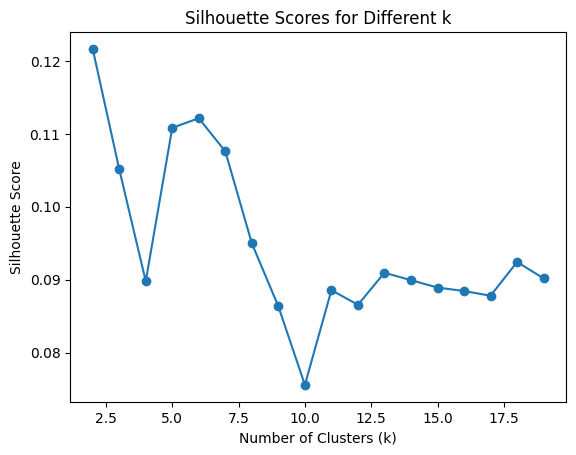

In [21]:
# Plot the silhouette scores for each k
silhouette_scores = []
k_range = range(2, 20)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    y_pred = kmeans.labels_
    score = silhouette_score(df_pca, y_pred)
    silhouette_scores.append(score)

plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

The silhouette scores confirm that K=6 creates the best clusters. This can also be seen in the plot below.

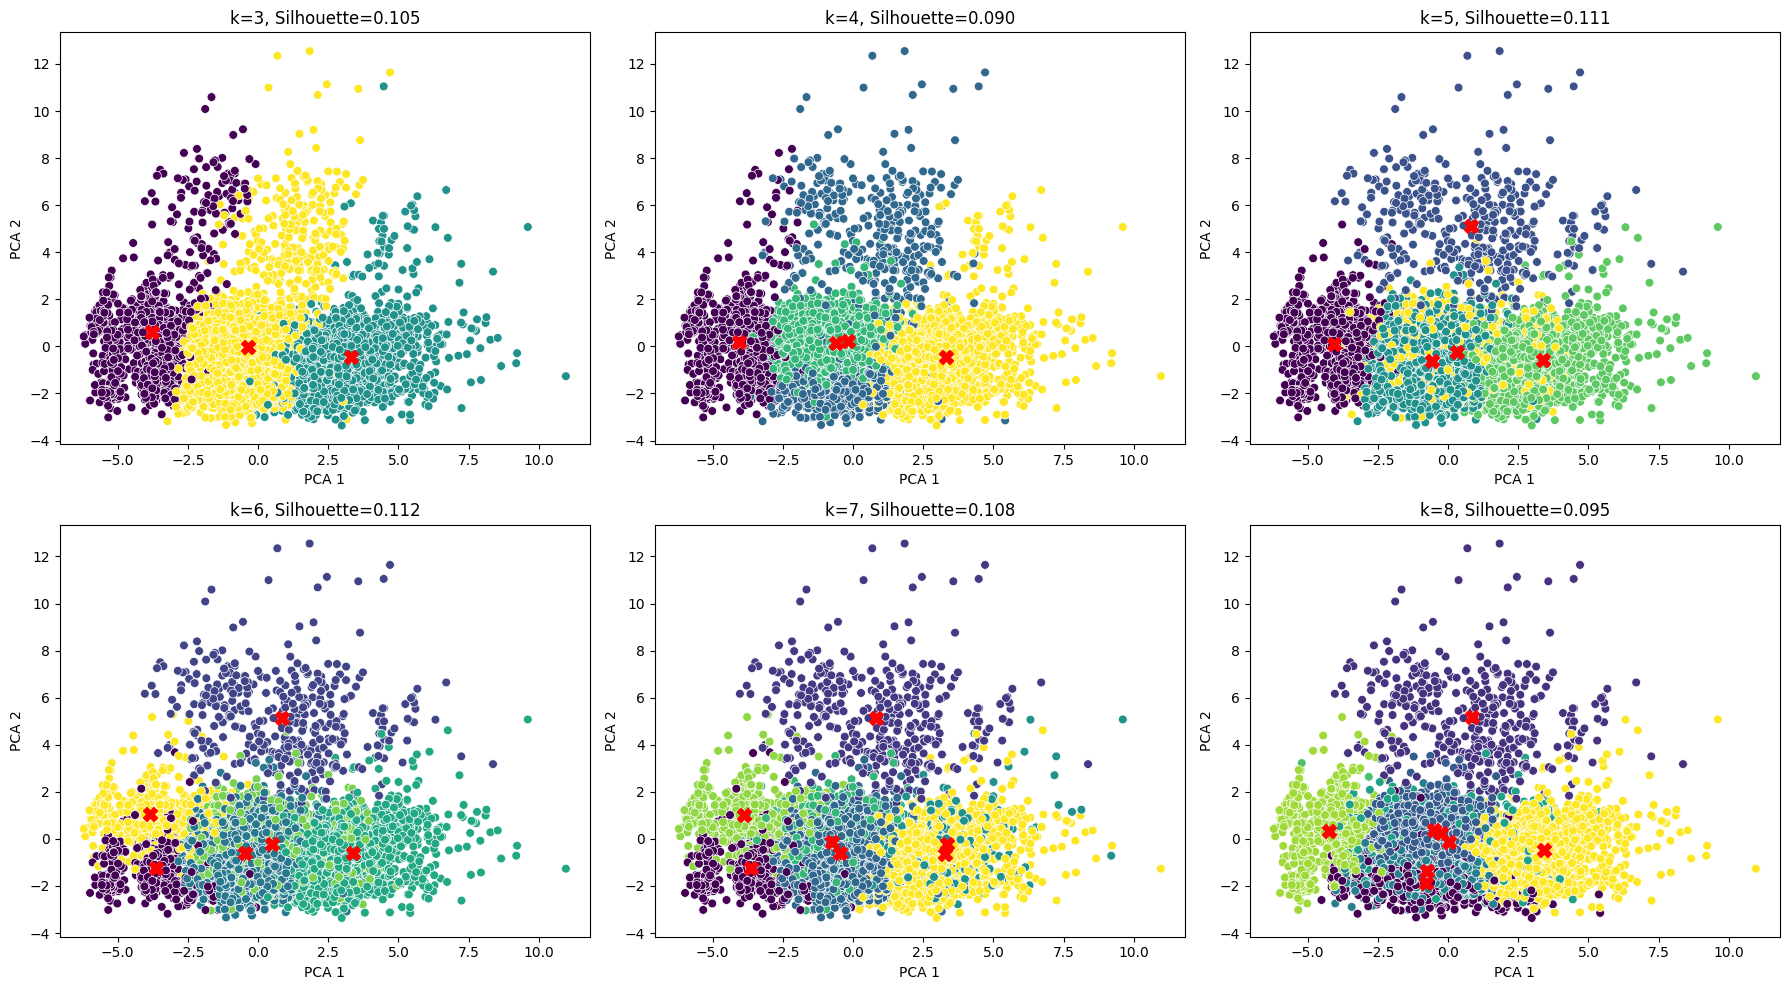

In [22]:
k_values = [3, 4, 5, 6, 7, 8]

plt.figure(figsize=(18, 10))
plot_num = 1

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_pca)

    sil_score = silhouette_score(df_pca, labels)

    # Plot the clusters in a subplot
    plt.subplot(2, 3, plot_num)
    sns.scatterplot(
        x=df_pca.iloc[:, 0],
        y=df_pca.iloc[:, 1],
        hue=labels,
        palette='viridis',
        s=40,
        legend=False
    )
    plt.scatter(
        kmeans.cluster_centers_[:, 0],
        kmeans.cluster_centers_[:, 1],
        c='red',
        marker='X',
        s=100,
        label='Centroids'
    )
    plt.title(f'k={k}, Silhouette={sil_score:.3f}')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plot_num += 1

plt.tight_layout()
plt.show()

## K-Mean Groups

We create 6 groups based on the results of the K-Means Clustering.

In [23]:
kmeans = KMeans(n_clusters=6)
kmean_groups = kmeans.fit_predict(df_pca)
kmean_groups

array([5, 5, 3, ..., 0, 0, 1], dtype=int32)

Here we can see the distribution accross the K-Means groups. They are fairly well distributed.

In [24]:
kmean_groups = pd.DataFrame(kmean_groups)
kmean_groups.index = df_pca.index
kmean_groups.columns = ["kmean_groups"]
kmean_groups.value_counts().sort_index()

kmean_groups
0                630
1                899
2                393
3               1268
4                955
5               1097
Name: count, dtype: int64

We will add the K-Means groups to our data.

In [25]:
df_pca['kmean_groups'] = kmean_groups
df['kmean_groups'] = kmean_groups

Here we can see our data with the final K-Mean groups in 2D space.

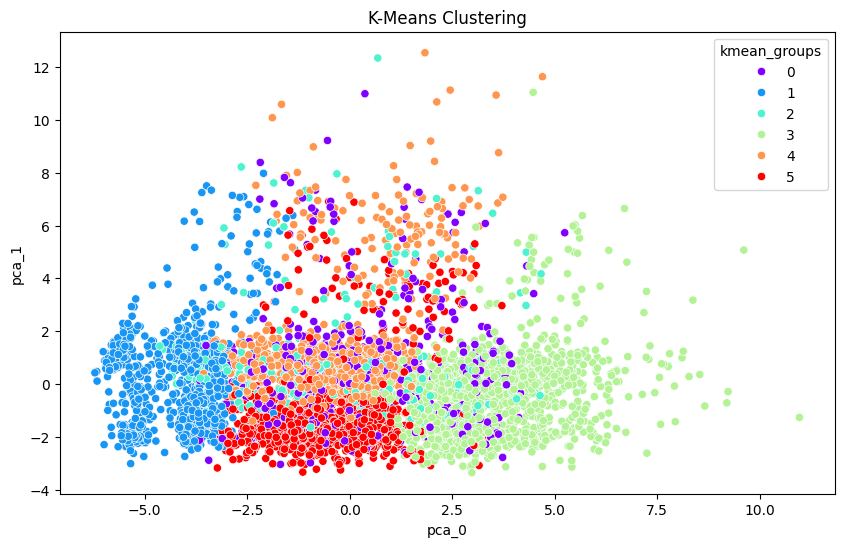

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca,x="pca_0",y="pca_1",hue="kmean_groups",palette="rainbow",legend='full')
plt.title("K-Means Clustering")
plt.show()

# DBSCAN

**Determining Optimal Parameters:**

* The k-Distance graph is used to help select the epsilon (ε) parameter. The "elbow point" where the curve begins to steepen dramatically is around 5-6, suggesting this might be an appropriate ε value.


**Parameter Tuning Results:**

* Multiple DBSCANs were run with varying epsilon (ε) and min_samples parameters, showing how different settings affect cluster identification.
* The comprehensive results with silhouette scores for various parameter combinations are stored in a table for overview.
* The highest silhouette scores (quality of clustering) occur with ε values between 7.5-10.0, reaching ~0.46.


**Best Clustering Solutions:**

* The best parameter combinations appear to be around `eps=7.5` with `min_samples=2-7`, or `eps=8.0-10.0` with appropriate min_samples values.
* These configurations yield silhouette scores above 0.43, indicating reasonably good cluster separation.


**Customer Distribution:**

* The vast majority of customers (5,193) belong to cluster 0, which likely represents the "mainstream" customers or noise points.
* There are 5 customers labeled as -1, indicating they're classified as noise/outliers.
* Smaller clusters (1, 2, 3) contain 27, 7, and 10 customers, respectively, suggesting niche customer segments.


**Visual Patterns in Clustering:**

* The final clustering solution with higher eps values (7.5-10.0) reveals clearer separation between clusters.
* The data appears to have 2-4 natural clusters.


These 5 customer segments likely represent different travel behaviors and demographics:

* `Luxury Family Travelers`
* `Standard Solo Travelers`
* `Frequent Business Travelers`
* `Standard Family Travelers`
* `Single Parents`


## K Nearest Neighbours

We start with using KNN to determine the best starting value for our eps hyperparameter.

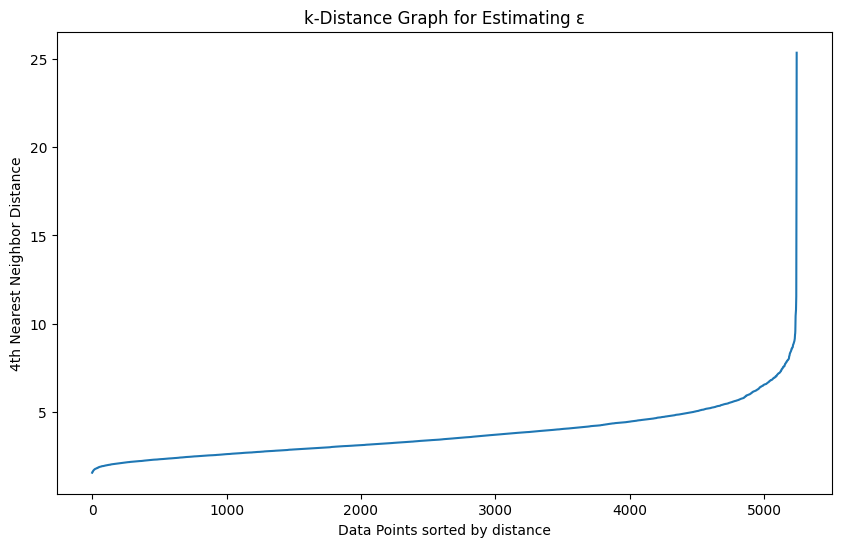

In [27]:
# Use NearestNeighbors to compute the k-distance
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_pca)
distances, indices = neighbors_fit.kneighbors(df_pca)

# Sort distances
distances = np.sort(distances[:, 4], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title("k-Distance Graph for Estimating ε")
plt.xlabel("Data Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.show()

It seems that our optimal eps value is between 5 and 10.

## Hyperparameter Tuning

We will test different hyperparameter values to determine the best combination with the best clusters and score.

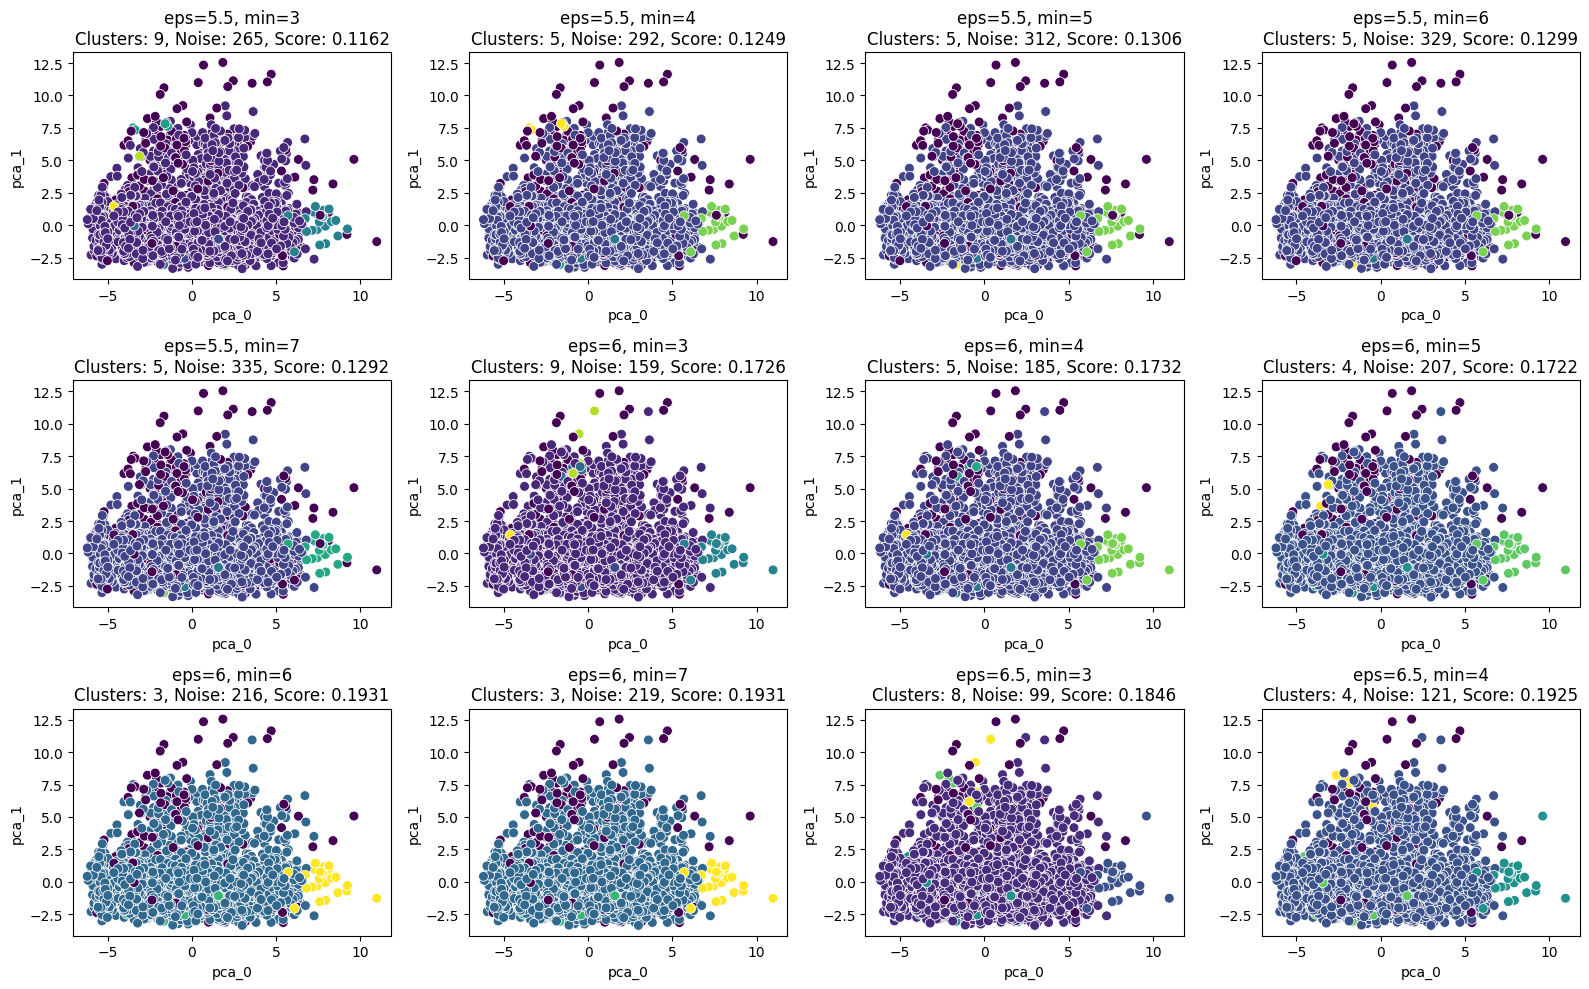

In [28]:
# Try different DBSCAN parameters Gridsearch
eps_values = [5.5, 6, 6.5, 7, 7.5]
min_samples_values = [3, 4, 5, 6, 7]

plt.figure(figsize=(16, 10))
plot_num = 1

# Loop through combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        if plot_num > 12:
            break

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_pca)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        sil_score = silhouette_score(df_pca, labels)

        plt.subplot(3, 4, plot_num)
        sns.scatterplot(
            x=df_pca.iloc[:, 0],
            y=df_pca.iloc[:, 1],
            hue=labels,
            palette='viridis',
            s=50,
            legend=False
        )
        plt.title(f'eps={eps}, min={min_samples}\nClusters: {n_clusters}, Noise: {n_noise}, Score: {sil_score:.4f}')
        plot_num += 1

plt.tight_layout()
plt.show()

Here is an overview of all the combinations that were tried during manual hyperparameter tuning.

In [29]:
results = [
    {"eps": 6.5, "min_samples": 4, "clusters": 4, "noise_points": 119, "silhouette": 0.2000},
    {"eps": 6.5, "min_samples": 3, "clusters": 7, "noise_points": 99, "silhouette": 0.1957},
    {"eps": 6.5, "min_samples": 5, "clusters": 3, "noise_points": 132, "silhouette": 0.1991},
    {"eps": 7.5, "min_samples": 2, "clusters": 4, "noise_points": 33, "silhouette": 0.4321},
    {"eps": 7.5, "min_samples": 3, "clusters": 4, "noise_points": 33, "silhouette": 0.4321},
    {"eps": 7.5, "min_samples": 4, "clusters": 4, "noise_points": 35, "silhouette": 0.4304},
    {"eps": 7.5, "min_samples": 5, "clusters": 4, "noise_points": 41, "silhouette": 0.4362},
    {"eps": 7.5, "min_samples": 6, "clusters": 3, "noise_points": 50, "silhouette": 0.4469},
    {"eps": 7.5, "min_samples": 7, "clusters": 2, "noise_points": 59, "silhouette": 0.4543},
    {"eps": 5, "min_samples": 2, "clusters": 38, "noise_points": 351, "silhouette": -0.0382},
    {"eps": 5, "min_samples": 3, "clusters": 10, "noise_points": 407, "silhouette": 0.0891},
    {"eps": 5, "min_samples": 4, "clusters": 8, "noise_points": 437, "silhouette": 0.0498},
    {"eps": 5, "min_samples": 6, "clusters": 7, "noise_points": 505, "silhouette": 0.0647},
    {"eps": 5, "min_samples": 7, "clusters": 6, "noise_points": 529, "silhouette": 0.0663},
    {"eps": 7, "min_samples": 5, "clusters": 3, "noise_points": 71, "silhouette": 0.4327},
    {"eps": 7, "min_samples": 10, "clusters": 2, "noise_points": 101, "silhouette": 0.4233},
    {"eps": 8, "min_samples": 5, "clusters": 4, "noise_points": 25, "silhouette": 0.4549},
    {"eps": 8, "min_samples": 15, "clusters": 2, "noise_points": 51, "silhouette": 0.4576},
    {"eps": 8, "min_samples": 20, "clusters": 2, "noise_points": 54, "silhouette": 0.4568},
    {"eps": 8, "min_samples": 25, "clusters": 2, "noise_points": 58, "silhouette": 0.4540},
    {"eps": 9, "min_samples": 5, "clusters": 4, "noise_points": 9, "silhouette": 0.4616},
    {"eps": 9, "min_samples": 15, "clusters": 2, "noise_points": 28, "silhouette": 0.4594},
    {"eps": 10, "min_samples": 5, "clusters": 4, "noise_points": 7, "silhouette": 0.4617},
    {"eps": 10, "min_samples": 10, "clusters": 3, "noise_points": 14, "silhouette": 0.4611},
    {"eps": 10, "min_samples": 15, "clusters": 2, "noise_points": 24, "silhouette": 0.4596},
]

# Create the full DataFrame
results_df = pd.DataFrame(results)

# Filter for top results with silhouette > 0.4
top_results_df = results_df[results_df["silhouette"] > 0.4].sort_values(by="silhouette", ascending=False).reset_index(drop=True)

print("All Results:")
results_df

All Results:


eps  min_samples  clusters  noise_points  silhouette
0    6.5            4         4           119      0.2000
1    6.5            3         7            99      0.1957
2    6.5            5         3           132      0.1991
3    7.5            2         4            33      0.4321
4    7.5            3         4            33      0.4321
5    7.5            4         4            35      0.4304
6    7.5            5         4            41      0.4362
7    7.5            6         3            50      0.4469
8    7.5            7         2            59      0.4543
9    5.0            2        38           351     -0.0382
10   5.0            3        10           407      0.0891
11   5.0            4         8           437      0.0498
12   5.0            6         7           505      0.0647
13   5.0            7         6           529      0.0663
14   7.0            5         3            71      0.4327
15   7.0           10         2           101      0.4233
16   8.0            5         4            25      0.4549
17   8.0           15         2            51      0.4576
18   8.0           20         2            54      0.4568
19   8.0           25         2            58      0.4540
20   9.0            5         4             9      0.4616
21   9.0           15         2            28      0.4594
22  10.0            5         4             7      0.4617
23  10.0           10         3            14      0.4611
24  10.0           15         2            24      0.4596

The resuluts with scores in the top 12 of all iterations are visualized below.

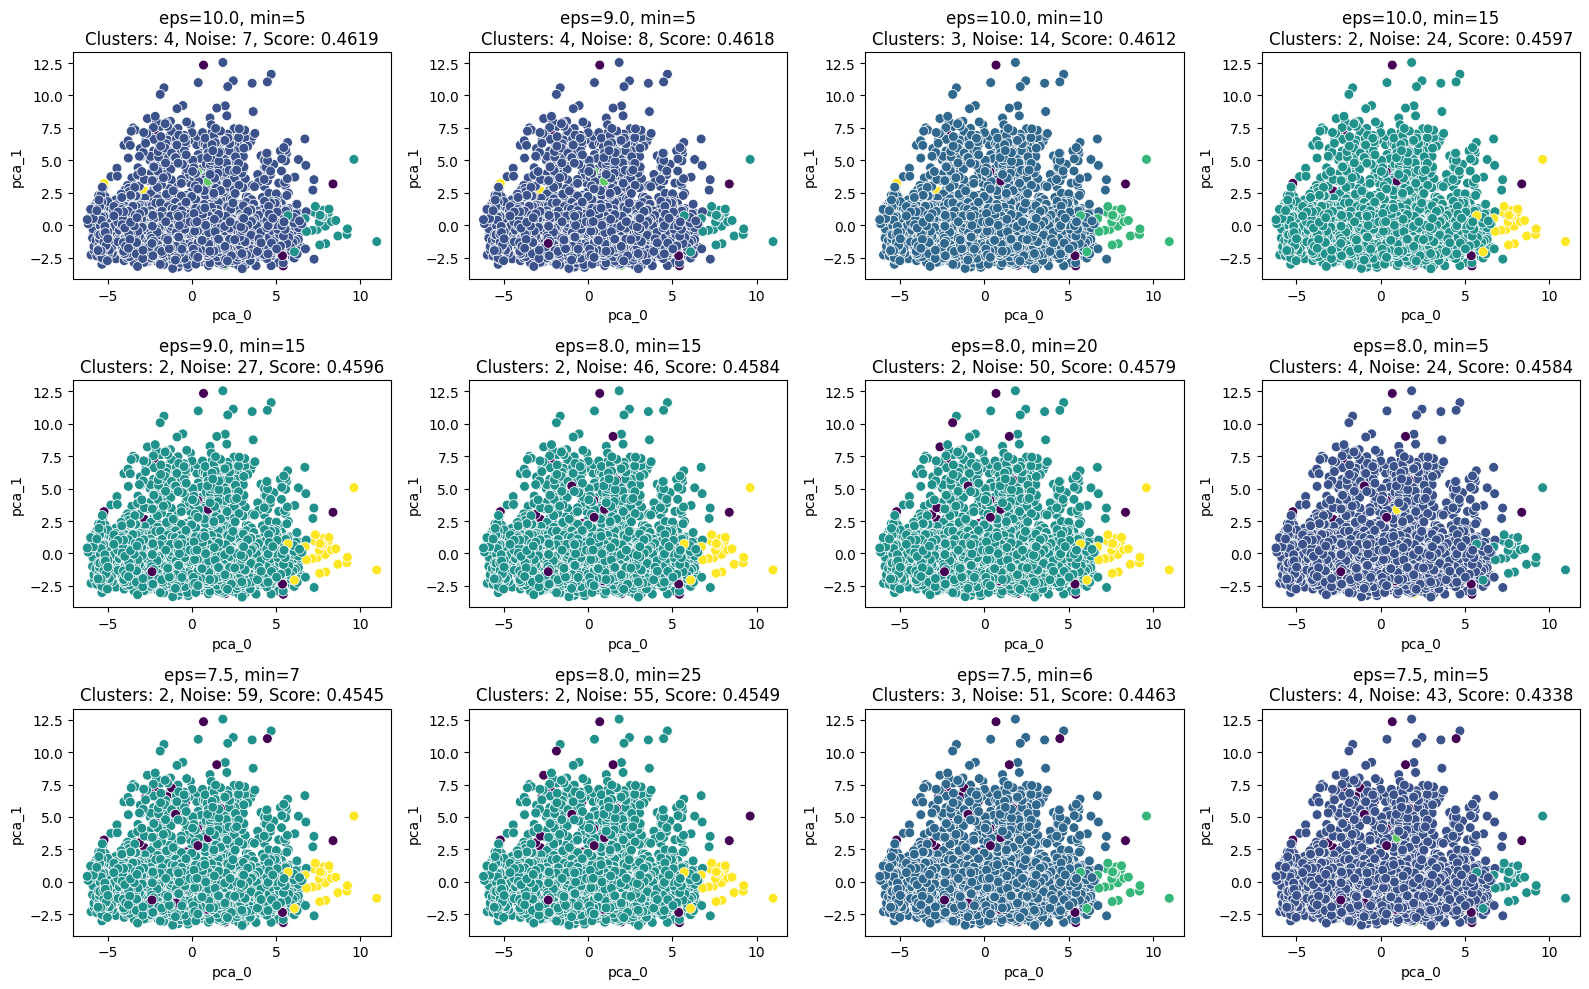

In [30]:
# Select top 12 results
top_12 = top_results_df.sort_values(by="silhouette", ascending=False).head(12)

plt.figure(figsize=(16, 10))

# Loop over each row in the top 12
for plot_num, row in enumerate(top_12.itertuples(), start=1):
    eps = row.eps
    min_samples = row.min_samples

    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(df_pca)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    sil_score = silhouette_score(df_pca, labels)

    # Plot the clustering result
    plt.subplot(3, 4, plot_num)
    sns.scatterplot(
        x=df_pca.iloc[:, 0],
        y=df_pca.iloc[:, 1],
        hue=labels,
        palette='viridis',
        s=50,
        legend=False
    )
    plt.title(f'eps={eps}, min={min_samples}\nClusters: {n_clusters}, Noise: {n_noise}, Score: {sil_score:.4f}')

plt.tight_layout()
plt.show()

## DBSCAN Groups

Based on the hyperparameter tuning, we will create DBSCAN groups with `eps=10` and `min_samples=5`, which had the best silhouette score (0.47).

The distibution in the groups is extremly unbalanced.

In [31]:
dbscan = DBSCAN(eps=10, min_samples=5)
groups_dbscan = dbscan.fit_predict(df_pca)
groups_dbscan = pd.DataFrame(groups_dbscan)
groups_dbscan.index = df_pca.index
groups_dbscan.columns = ["groups_dbscan"]
groups_dbscan.value_counts().sort_index()

groups_dbscan
-1                  7
 0               5191
 1                 27
 2                  7
 3                 10
Name: count, dtype: int64

We will add the DBSCAN groups to our data.

In [32]:
df_pca['dbscan_groups'] = groups_dbscan
df['dbscan_groups'] = groups_dbscan

In the next phase of this project we will analyze the groups created by K-Means and DBSCAN. The characteristics of each group can tell us more about the users, their behaviors, and their needs.

# Saving and Reusing the Models

To ensure reusability and enable future predictions, the trained KMeans and DBSCAN model was saved using `joblib`.

These saved components can later be loaded and applied to new customer data, enabling segmentation without retraining the model.

In [33]:
#import joblib
#import os

#os.makedirs('models', exist_ok=True)
#joblib.dump(kmeans, 'models/kmeans_model.pkl')
#joblib.dump(dbscan, 'models/dbscan_model.pkl')